<a href="https://colab.research.google.com/github/CyberIngeniero/Bike_identification_CovNet/blob/main/cnn_bike_v5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Classification with Convolutional Neural Networks
Steps:

1.   Explore the Data of bikes and no bikes
2.   Build and Train a Neural Network to recognize the difference between the two
3.   Evaluate the Training and Validation accuracy or F1-score

## Preliminaries

### Libraries 

In [1]:
# Importing necessary libraries
from google.colab import drive
from google.colab import files
from google.colab.patches import cv2_imshow

import pathlib
import shutil
import os
import random
import glob

from psutil import virtual_memory
from shutil import copyfile

import numpy as np
import pandas as pd
import itertools
import cv2

import keras
from keras import backend as K
from keras.callbacks import Callback
from keras.preprocessing import image

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout, GlobalMaxPooling2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import *

from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

from skimage import io, color, restoration, img_as_float
from skimage.morphology import selem
from skimage.morphology import binary_closing, binary_dilation, binary_erosion, binary_opening
from skimage import feature
from skimage.feature import canny
from skimage import transform
from skimage.transform import rescale, resize, downscale_local_mean
from skimage.filters import roberts, sobel, scharr, prewitt

from PIL import Image

import scipy.stats as st
from scipy.ndimage import maximum_filter, minimum_filter

%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

### Functions

In [2]:
def get_info_gpu():
    '''
    This function print info to gpu environment.
    '''
    gpu_info = !nvidia-smi
    gpu_info = '\n'.join(gpu_info)
    if gpu_info.find('failed') >= 0:
        print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
        print('and then re-execute this cell.')
    else:
        print(gpu_info)

#----------------------------------------------------------------------------------------

def runtime_memory():
    '''
    Print runtime memory
    '''
    ram_gb = virtual_memory().total / 1e9
    print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

    if ram_gb < 20:
        print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
        print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
        print('re-execute this cell.')
    else:
        print('You are using a high-RAM runtime!')

#----------------------------------------------------------------------------------------    

def print_radom_photos(nrows,ncols, train_bikes_dir, train_nobikes_dir):
    '''
    Print random photos
    '''
    pic_index = 0 

    fig = plt.gcf()
    fig.set_size_inches(ncols*4, nrows*4)

    pic_index+=8

    next_bike_pix = [os.path.join(train_bikes_dir, fname) 
                    for fname in train_bikes_fnames[ pic_index-8:pic_index] 
                ]

    next_nobike_pix = [os.path.join(train_nobikes_dir, fname) 
                    for fname in train_nobikes_fnames[ pic_index-8:pic_index]
                ]

    for i, img_path in enumerate(next_bike_pix + next_nobike_pix):
        sp = plt.subplot(nrows, ncols, i + 1)
        sp.axis('Off')

        img = mpimg.imread(img_path)
        plt.imshow(img)

    plt.show();

#----------------------------------------------------------------------------------------    

def plot_image(images, captions=None, cmap=None ):
    '''
    function to plot n images using subplots
    '''
    f, axes = plt.subplots(1, len(images), sharey=True)
    f.set_figwidth(15)
    for ax,image in zip(axes, images):
        ax.imshow(image, cmap)

#----------------------------------------------------------------------------------------

def ConvertImages_to_JPG(path):
    '''
    change the image format to jpg
    '''
    names = []
    for file in os.listdir(path):
        if (file.endswith('.png') or file.endswith('.bmp') or file.endswith('.gif')):
            names.append(file)
    
    for i in range(len(names)):
        im_dir = os.path.join(path, names[i])
        im = Image.open(im_dir)
        rgb_im = im.convert('RGB')
        rgb_im.save(path + 'rgb_' + str(i) + '.jpg', "JPEG")

    for i in range(len(names)):
        im_remove = os.path.join(path, names[i])
        os.remove(im_remove)

#---------------------------------------------------------------------------------------------

def gkern(kernlen=21, nsig=2):    #Returns a 2D Gaussian kernel.

    lim = kernlen//2 + (kernlen % 2)/2
    x = np.linspace(-lim, lim, kernlen+1)
    kern1d = np.diff(st.norm.cdf(x))
    kern2d = np.outer(kern1d, kern1d)
    return kern2d/kern2d.sum()

#---------------------------------------------------------------------------------------------

def midpoint(img):
    maxf = maximum_filter(img, (3, 3))
    minf = minimum_filter(img, (3, 3))
    midpoint = (maxf + minf) / 2
    #cv2_imshow(midpoint)

#---------------------------------------------------------------------------------------------    

def contraharmonic_mean(img, size, Q):
    num = np.power(img, Q + 1)
    denom = np.power(img, Q)
    kernel = np.full(size, 1.0)
    result = cv2.filter2D(num, -1, kernel) / cv2.filter2D(denom, -1, kernel)
    return result     

#---------------------------------------------------------------------------------------------  

def salt_pepper(img_gs, prob):
      # Extract image dimensions
      row, col = img_gs.shape

      # Declare salt & pepper noise ratio
      s_vs_p = 0.5
      output = np.copy(img_gs)

      # Apply salt noise on each pixel individually
      num_salt = np.ceil(prob * img_gs.size * s_vs_p)
      coords = [np.random.randint(0, i - 1, int(num_salt))
            for i in img_gs.shape]
      output[coords] = 1

      # Apply pepper noise on each pixel individually
      num_pepper = np.ceil(prob * img_gs.size * (1. - s_vs_p))
      coords = [np.random.randint(0, i - 1, int(num_pepper))
            for i in img_gs.shape]
      output[coords] = 0
      cv2_imshow(output)

      return output           

#---------------------------------------------------------------------------------------------

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  """
  This function prints and plots the confusion matrix.
  Normalization can be applied by setting `normalize=True`.
  """
  if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
      print("Normalized confusion matrix")
  else:
      print('Confusion matrix, without normalization')

  print(cm)

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt),
               horizontalalignment="center",
               color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show();

#---------------------------------------------------------------------------------------------  

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true.argmax(axis=1) * y_pred.argmax(axis=1), 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true.argmax(axis=1), 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

#---------------------------------------------------------------------------------------------    

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true.argmax(axis=1) * y_pred.argmax(axis=1), 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred.argmax(axis=1), 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

#---------------------------------------------------------------------------------------------    

def f1_m(y_true, y_pred):
    precision = precision_m(y_true.argmax(axis=1), y_pred.argmax(axis=1))
    recall = recall_m(y_true.argmax(axis=1), y_pred.argmax(axis=1))
    return 2*((precision*recall)/(precision + recall + K.epsilon()))

#-----------------------------------------------------------------------------------------------

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  """
  This function prints and plots the confusion matrix.
  Normalization can be applied by setting `normalize=True`.
  """
  if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
      print("Normalized confusion matrix")
  else:
      print('Confusion matrix, without normalization')

  print(cm)

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt),
               horizontalalignment="center",
               color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

#-----------------------------------------------------------------------------------------------

# Display two images
def display(a, b, title1 = "Original", title2 = "Edited"):
    plt.subplot(121), plt.imshow(a), plt.title(title1)
    plt.xticks([]), plt.yticks([])
    plt.subplot(122), plt.imshow(b, cmap='gray'), plt.title(title2)
    plt.xticks([]), plt.yticks([])
    plt.show()

#-----------------------------------------------------------------------------------------------

#Funcion para plotear imagenes horizontalmente
def plot_7_images(dataset,classes):

  %matplotlib inline
  axoff_fun = np.vectorize(lambda axs:axs.axis('off'))
  print('Some Images:\n')
  fig, axs = plt.subplots(nrows=1, ncols= 7, figsize= (20,10))
  axoff_fun(axs)

  for i, ax in enumerate(axs.flatten()):
    plt.sca(ax) 
    if dataset[i].shape[2] == 1:
      image_plot = dataset[i][:, :, 0]

    plt.imshow(image_plot, cmap='gray')
    #plt.colorbar()
    plt.title('Clase: {}'.format(classes[i][1]))

## Info GPU Environment

In [3]:
get_info_gpu()

Wed Apr 21 13:49:20 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
runtime_memory()

Your runtime has 27.4 gigabytes of available RAM

You are using a high-RAM runtime!


## Configure Environment

### Drive mount

In [5]:
drive.mount('/drive', force_remount=True)

Mounted at /drive


### Get Data and Create Directory

In [6]:
drive_src = "/drive/MyDrive/Proyectos/Reconocimiento_Bicicleta/data_bike"
local_dest = "/tmp/data_bike"

shutil.rmtree("/tmp")
shutil.copytree(drive_src, local_dest)

'/tmp/data_bike'

### Create a copy of data in other directory (original data)

In [7]:
try:
    shutil.copytree("/tmp/data_bike", "/tmp/data_bike_backup")
except:
    pass

### Define each of these directories.

In [8]:
# Base Directory
base_dir = '/tmp/data_bike'

In [9]:
# Train, Validation and Test Directory
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

# Directory with our training pictures
train_bikes_dir = os.path.join(train_dir, 'bike')
train_nobikes_dir = os.path.join(train_dir, 'no_bike')

# Directory with our validation pictures
validation_bikes_dir = os.path.join(validation_dir, 'bike')
validation_nobikes_dir = os.path.join(validation_dir, 'no_bike')

# Directory with our validation pictures
test_bikes_dir = os.path.join(test_dir, 'bike')
test_nobikes_dir = os.path.join(test_dir, 'no_bike')

###Cambio de formato png a jpeg

In [10]:
#Convierte Imagener a jpg desde directorio de origen
dir_folders = ['train', 'validation', 'test']
class_ = ['bike', 'no_bike']

for folder in dir_folders:
    dir_ = os.path.join(base_dir, folder)
    for clase in class_:
        dir_class_ = os.path.join(dir_, clase)
        ConvertImages_to_JPG(dir_class_)

### Filenames look like in the `bikes` and `no_bikes` `train` directories.

In [11]:
# Filenames look like in the bikes and no_bikes train directories.
train_bikes_fnames = os.listdir(train_bikes_dir)
train_nobikes_fnames = os.listdir(train_nobikes_dir)

print(train_bikes_fnames[:5])
print(train_nobikes_fnames[:5])

['bicicleta_rgb_19.jpg', 'thumbbig-260517.jpg', 'bicicleta (784).jpg', 'bicicleta_2 (157).jpg', 'bicicleta (231).jpeg']
['steering-wheel-1184126__480.jpg', 'moto (104).jpg', '01020.jpg', '00201.jpg', '01174.jpg']


### Total number of bikes and no bikes images in the `train` and `validation` directories.

In [12]:
print('total training bikes images :', len(os.listdir(train_bikes_dir)))
print('total training no_bikes images :', len(os.listdir(train_nobikes_dir)))

print('total validation bikes images :', len(os.listdir(validation_bikes_dir)))
print('total validation no_bikes images :', len(os.listdir(validation_nobikes_dir)))

print('total test bikes images :', len(os.listdir(test_bikes_dir)))
print('total test no_bikes images :', len(os.listdir(test_nobikes_dir)))

total training bikes images : 2839
total training no_bikes images : 2920
total validation bikes images : 604
total validation no_bikes images : 824
total test bikes images : 470
total test no_bikes images : 424


### Look at a few pictures.

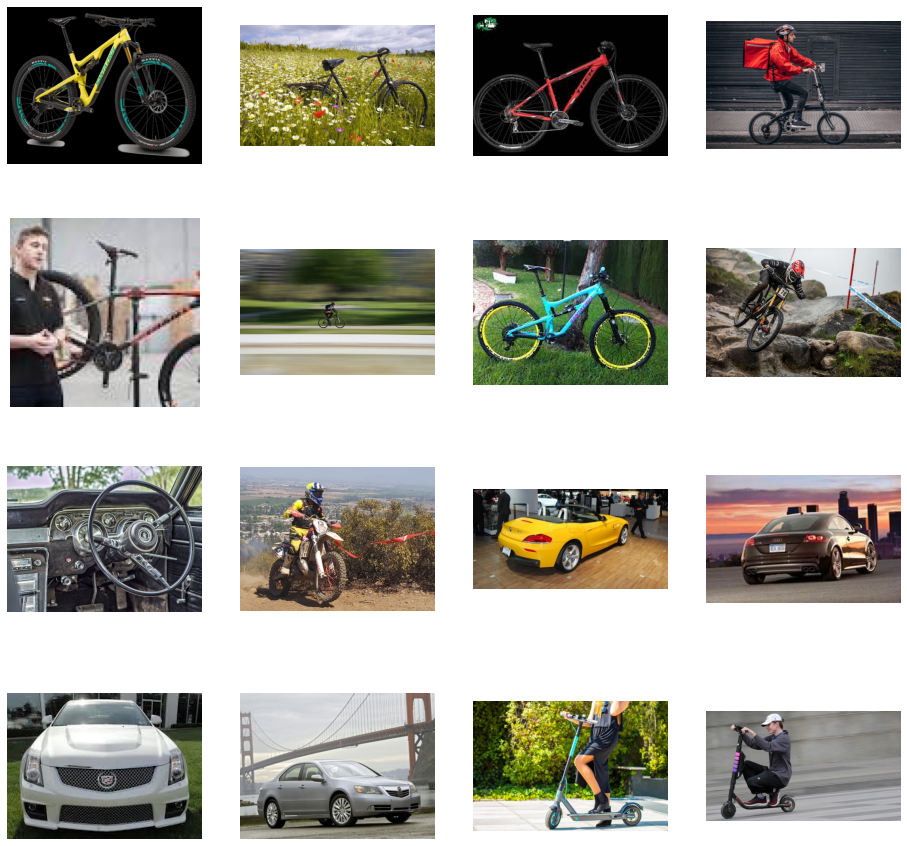

In [13]:
nrows = 4
ncols = 4

print_radom_photos(nrows,ncols, train_bikes_dir, train_nobikes_dir)

#### Dimensions Distributions

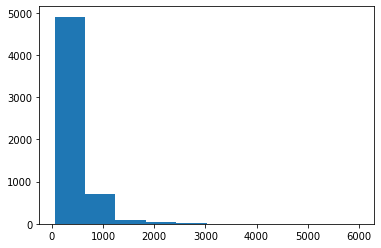

Tamaño imagenes: 290 x 400


In [14]:
# analizer of zise distributions
dir_folders = ['train']
class_ = ['bike', 'no_bike']

formatos = []

#Busqueda del ancho y alto mas chico
for folder in dir_folders:
    dir_ = os.path.join(base_dir, folder)
    for clase in class_:
        dir_class = os.path.join(dir_, clase)
        for filename in os.listdir(dir_class):
          img = cv2.imread(os.path.join(dir_class,filename))
          formatos.append(img.shape)

formatos = pd.DataFrame(formatos, columns=['Alto', 'Ancho', 'Colores'])

formatos['Tamaño_imagen'] = formatos['Alto'].astype(str) + '-' + formatos['Ancho'].astype(str)
formatos.head()

min_ancho = np.percentile(formatos['Ancho'],25).astype('int32')
min_alto = np.percentile(formatos['Alto'],25).astype('int32')

plt.hist(formatos['Alto'])
plt.show()

print('Tamaño imagenes: {} x {}'.format(min_alto, min_ancho))


In [15]:
formatos.describe()

Alto        Ancho  Colores
count  5759.000000  5759.000000   5759.0
mean    472.813683   660.455114      3.0
std     345.165686   471.061066      0.0
min      53.000000    85.000000      3.0
25%     290.500000   400.000000      3.0
50%     408.000000   612.000000      3.0
75%     480.000000   720.000000      3.0
max    6000.000000  6720.000000      3.0

In [16]:
# Size defined
final_size = min(min_ancho, min_alto)
print('Tamaño a utilizar: {} x {}'.format(final_size, final_size))

Tamaño a utilizar: 290 x 290


## Data Preprocessing Summary

### ImageDataGenerator

- Data augmentation is a strategy used to increase the amount of data by using techniques like cropping, padding, flipping, etc.
- Data augmentation makes the model more robust to slight variations, and hence prevents the model from overfitting.
- It is neither practical nor efficient to store the augmented data in memory, and that is where the ImageDataGenerator class from Keras comes into play.
- ImageDataGenerator generates batches of tensor image data with real-time data augmentation.

#### Internal Data Preprocessing in ImageDataGenerator

In [17]:
# glob through the directory (returns a list of all file paths)
bike_path = os.path.join(train_bikes_dir, '*')
bike_path = glob.glob(bike_path)

# random image
n = random.randint(0,len(bike_path))

# access some random element (a file) from the list
img = io.imread(bike_path[n])

##### Images — Channels and Sizes
plotting the original image and the RGB channels

Text(0.5, 0.98, 'Different Channels of Image')

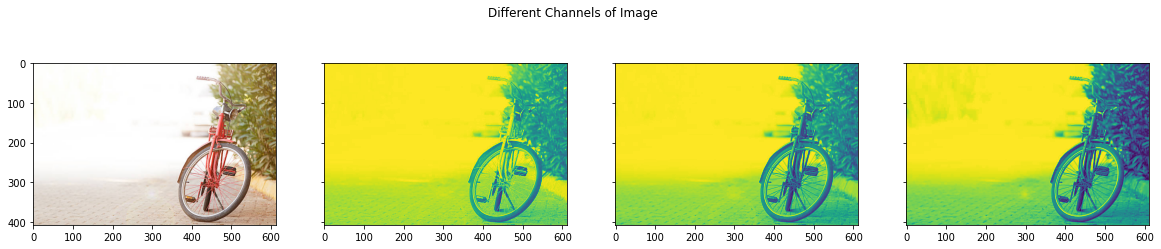

In [18]:
# plotting the original image and the RGB channels
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, sharey=True)
f.set_figwidth(20)
ax1.imshow(img)

# RGB channels
# CHANNELID : 0 for Red, 1 for Green, 2 for Blue. 
ax2.imshow(img[:, : , 0]) #Red
ax3.imshow(img[:, : , 1]) #Green
ax4.imshow(img[:, : , 2]) #Blue
f.suptitle('Different Channels of Image')

##### Morphological Transformations

###### 1. Thresholding
One of the simpler operations where we take all the pixels whose intensities are above a certain threshold and convert them to ones; the pixels having value less than the threshold are converted to zero. This results in a binary image.

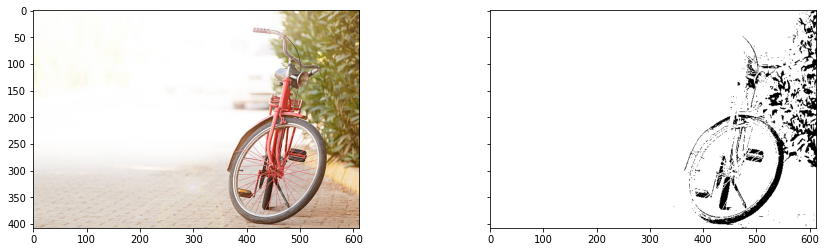

In [19]:
# bin_image will be a (240, 320) True/False array
#The range of pixel varies between 0 to 255
#The pixel having black is more close to 0 and pixel which is white is more close to 255
# 125 is Arbitrary heuristic measure halfway between 1 and 255 (the range of image pixel) 
bin_image = img[:, :, 0] > 125
plot_image([img, bin_image], cmap='gray')

###### 2. Erosion, Dilation, Opening & Closing

- Erosion shrinks bright regions and enlarges dark regions. Dilation on the other hand is exact opposite side — it shrinks dark regions and enlarges the bright regions.
- Opening is erosion followed by dilation. Opening can remove small bright spots (i.e. “salt”) and connect small dark cracks. This tends to “open” up (dark) gaps between (bright) features.
- Closing is dilation followed by erosion. Closing can remove small dark spots (i.e. “pepper”) and connect small bright cracks. This tends to “close” up (dark) gaps between (bright) features.

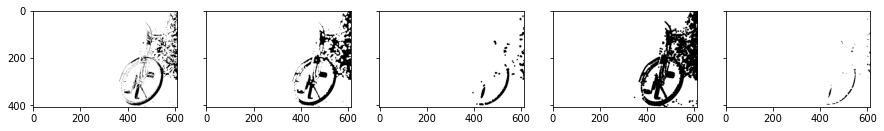

In [20]:
from skimage.morphology import selem
# use a disk of radius 3
selem = selem.disk(3)

# oprning and closing
open_img = binary_opening(bin_image, selem)
close_img = binary_closing(bin_image, selem)

# erosion and dilation
eroded_img = binary_erosion(bin_image, selem)
dilated_img = binary_dilation(bin_image, selem)

plot_image([bin_image, open_img, close_img, eroded_img, dilated_img], cmap='gray')

###### 3. Normalization
Normalization is the most crucial step in the pre-processing part. This refers to rescaling the pixel values so that they lie within a confined range. One of the reasons to do this is to help with the issue of propagating gradients. There are multiple ways to normalize images that we will be talking about.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


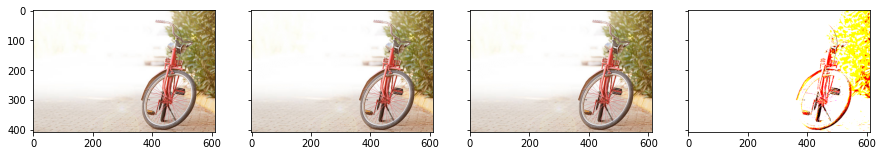

In [21]:
#way1-this is common technique followed in case of RGB images 
norm1_image = img/255
#way2-in case of medical Images/non natural images 
norm2_image = (img - np.min(img))/(np.max(img) - np.min(img))
#way3-in case of medical Images/non natural images 
norm3_image = img - np.percentile(img,5)/ np.percentile(img,95) - np.percentile(img,5)

plot_image([img, norm1_image, norm2_image, norm3_image], cmap='gray')

##### Augmentation

##### 1. Linear Transform

###### flip left-right, up-down

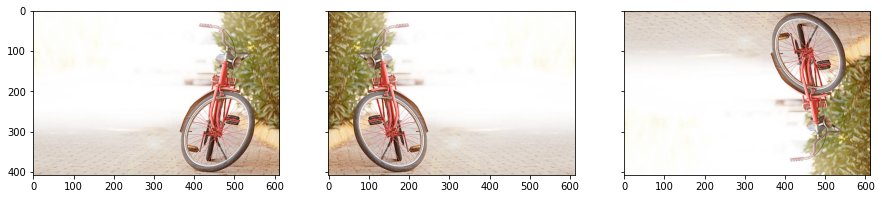

In [22]:
# flip left-right, up-down
image_flipr = np.fliplr(img)
image_flipud = np.flipud(img)

plot_image([img, image_flipr, image_flipud])

##### 2. Affine transformations

###### shifting

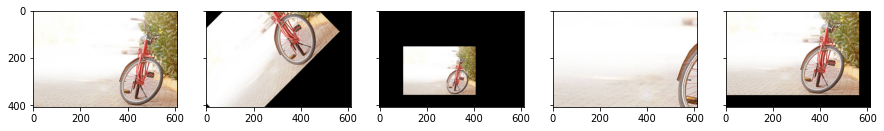

In [23]:
# specify x and y coordinates to be used for shifting (mid points)
shift_x, shift_y = img.shape[0]/2, img.shape[1]/2

# translation by certain units
matrix_to_topleft = transform.SimilarityTransform(translation=[-shift_x, -shift_y])
matrix_to_center = transform.SimilarityTransform(translation=[shift_x, shift_y])

# rotation
rot_transforms =  transform.AffineTransform(rotation=np.deg2rad(45))
rot_matrix = matrix_to_topleft + rot_transforms + matrix_to_center
rot_image = transform.warp(img, rot_matrix)

# scaling 
scale_transforms = transform.AffineTransform(scale=(2, 2))
scale_matrix = matrix_to_topleft + scale_transforms + matrix_to_center
scale_image_zoom_out = transform.warp(img, scale_matrix)

scale_transforms = transform.AffineTransform(scale=(0.5, 0.5))
scale_matrix = matrix_to_topleft + scale_transforms + matrix_to_center
scale_image_zoom_in = transform.warp(img, scale_matrix)

# translation
transaltion_transforms = transform.AffineTransform(translation=(50, 50))
translated_image = transform.warp(img, transaltion_transforms)


plot_image([img, rot_image, scale_image_zoom_out, scale_image_zoom_in, translated_image])

###### shear transforms

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


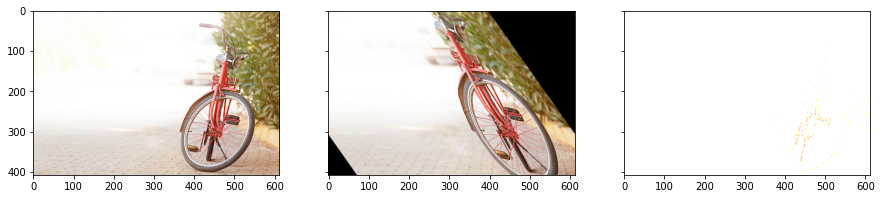

In [24]:
# shear transforms
shear_transforms = transform.AffineTransform(shear=np.deg2rad(45))
shear_matrix = matrix_to_topleft + shear_transforms + matrix_to_center
shear_image = transform.warp(img, shear_matrix)

bright_jitter = img*0.999 + np.zeros_like(img)*0.001

plot_image([img, shear_image, bright_jitter])

### Exploring Filters

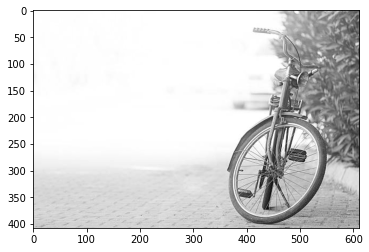

In [25]:
#Imagen de Ejemplo: Carga de imagen as gray scale
#img_path2 = os.path.join(train_bikes_dir,'bicicleta_2 (650).jpg')
#img2 = io.imread(img_path2, as_gray=True)
img2 = io.imread(bike_path[n], as_gray=True).astype(np.float32)
plt.imshow(img2, cmap='gray') 
plt.show();

#### Sobel Filter

The Sobel method, or Sobel filter, is a gradient-based method that looks for strong changes in the first derivative of an image. The Sobel edge detector uses a pair of 3 × 3 convolution masks, one estimating the gradient in the x-direction and the other in the y-direction.

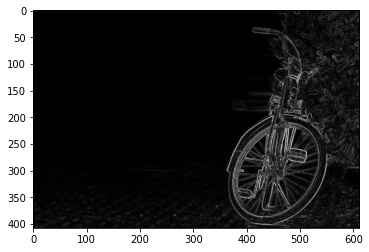

In [26]:
plt.imshow(sobel(img2), cmap = 'gray')
plt.show();

#### Prewitt Filter

The Prewitt operator is used in image processing, particularly within edge detection algorithms. Technically, it is a discrete differentiation operator, computing an approximation of the gradient of the image intensity function. At each point in the image, the result of the Prewitt operator is either the corresponding gradient vector or the norm of this vector. 

The Prewitt operator is based on convolving the image with a small, separable, and integer valued filter in horizontal and vertical directions and is therefore relatively inexpensive in terms of computations like Sobel and Kayyali operators. On the other hand, the gradient approximation which it produces is relatively crude, in particular for high frequency variations in the image.

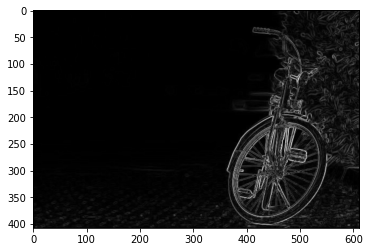

In [27]:
plt.imshow(prewitt(img2), cmap = 'gray')
plt.show();

#### Deconvolution Filter

In mathematics, deconvolution is the operation inverse to convolution. Both operation are used in signal processing and image processing. For example, convolution can be used to apply a filter, and it may be possible to recover the original signal using deconvolution.

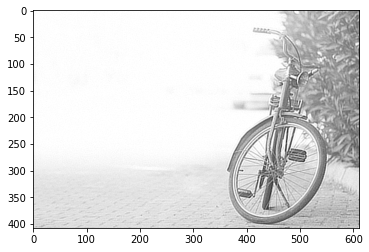

In [28]:
#Image deconvolution: Uses deconvolution to sharpen images. 
psf = gkern(5,3)   #Kernel length and sigma
deconvolved, _ = restoration.unsupervised_wiener(img2, psf)
plt.imshow(deconvolved, cmap = 'gray')
plt.show();

#### Roberts Filter

The Roberts filter belongs to the so called edge detection filters, you can use to only select the contours in an image and ignore everything else.

The Roberts filter registers transitions from light to dark pixels. It belongs to the class of non-linear filters for edge detection. It is made up of simple derivative filters.

Two 3x3 matrixes will be calculated. Only the difference in brightness of 2 values in both diagonals will be taken into consideration for each pixel. This filter is a very quick edge detection filter, due to the small number of calculations.

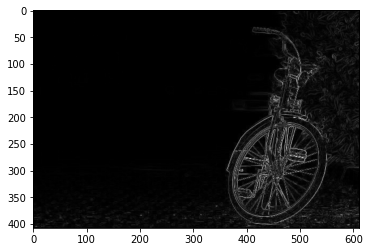

In [29]:
plt.imshow(roberts(img2), cmap = 'gray')
plt.show();

#### Scharr Filter

This is a filtering method used to identify and highlight gradient edges/features using the 1st derivative. Typically used to identify gradients along the x-axis (dx = 1, dy = 0) and y-axis (dx = 0, dy = 1) independently. 

Performance is quite similar to Sobel filter. Used to detect edges / changes in pixel intensity. ddepth = -1 specifies that the dimensions of output image will be the same as the input image.

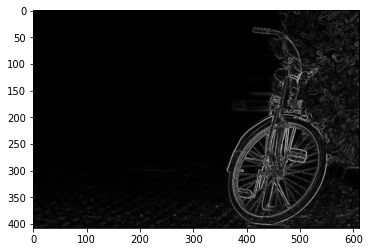

In [30]:
plt.imshow(scharr(img2), cmap = 'gray')
plt.show();

#### Canny Filter

Another edge filter is Canny. This is not just a single operation. It does noise reduction, gradient calculation, and edge tracking among other things. Canny creates a binary file, true or false pixels.

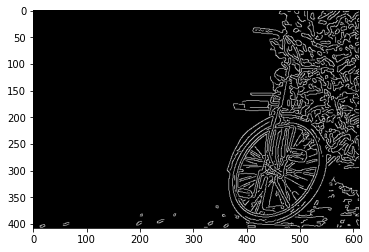

In [31]:
plt.imshow(feature.canny(img2, sigma=1.5), cmap='gray')
plt.show();

#### GaussianBlur Filter

Gaussian blur (also known as Gaussian smoothing) is the result of blurring an image by a Gaussian function. It is a widely used effect in graphics software, typically to reduce image noise. The visual effect of this blurring technique is a smooth blur resembling that of viewing the image through a translucent screen, distinctly different from the bokeh effect produced by an out-of-focus lens or the shadow of an object under usual illumination. Gaussian smoothing is also used as a pre-processing stage in computer vision algorithms in order to enhance image structures at different scales.

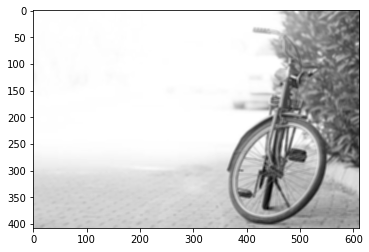

In [32]:
plt.imshow(cv2.GaussianBlur(img2, (5, 5), cv2.BORDER_DEFAULT), cmap='gray')
plt.show();

#### contraharmonic_mean Filter

This function will filter the image by the nonlinear contra-harmonic mean method. This function works for only monochrome, 8 bit per bixel and 24 bit per pixel images. The contra-harmonic mean filter is member of a set of nonlinear mean filters which are better at removing Gaussian type noise and preserving edge features than the arithmetic mean filter.

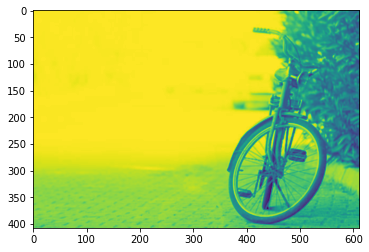

In [33]:
plt.imshow(contraharmonic_mean(img2, (3,3), 0.5))
plt.show();

#### Image thresholding

The concept of thresholding is quite simple. As discussed above in the image representation, pixel values can be any value between 0 to 255. Let's say we wish to convert an image into a binary image i.e. assign a pixel either a value of 0 or 1. To do this, we can perform thresholding. For instance, if the Threshold (T) value is 125, then all pixels with values greater than 125 would be assigned a value of 1, and all pixels with values lesser than or equal to that would be assigned a value of 0. Let's do that through code to get a better understanding.

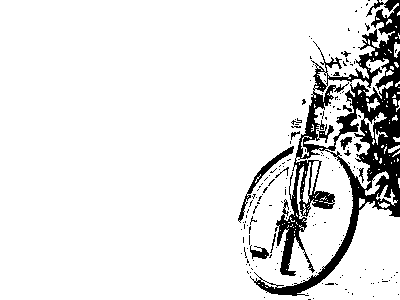

In [34]:
img = cv2.imread(bike_path[n], 0)
img = cv2.resize(img, (400, 300))

# Perform binary thresholding on the image with T = 125
r, threshold = cv2.threshold(img, 125, 255, cv2.THRESH_BINARY)
cv2_imshow(threshold)

#### Noisy Image Filter

'salt and pepper' noise to the grayscale

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:138: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


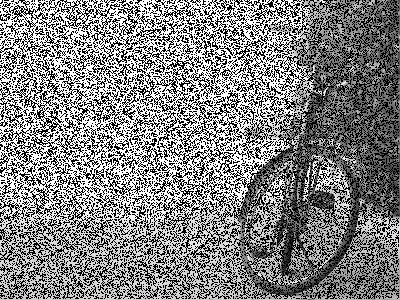

In [35]:
# Call salt & pepper function with probability = 0.5
sp = salt_pepper(img, 0.5);

## Data Preprocessing

### Resize and grayscale transform over all images

In [36]:
# Aplicacion de redimensionamiento y lectura en gray color
dir_folders = ['train', 'validation', 'test']
class_ = ['bike', 'no_bike']

images = []

for folder in dir_folders:
    dir_ = os.path.join(base_dir, folder)
    for clase in class_:
        dir_class = os.path.join(dir_, clase)
        for filename in os.listdir(dir_class):
          dir_img = os.path.join(dir_class,filename)
          img = io.imread(dir_img, as_gray=True).astype(np.float32)
          img_resized = resize(img, (final_size, final_size), anti_aliasing=True)
          #sobel_img = sobel(img)  
          images.append(img_resized)
          plt.imsave(os.path.join(dir_class,filename),img_resized)

#### Some images examples with grayscale

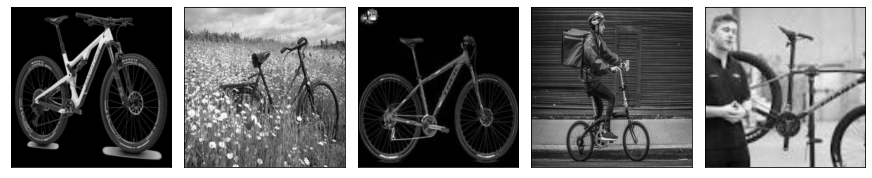

In [37]:
# Revision de algunas imagenes con grayscale
fig, ax = plt.subplots(nrows=1,ncols=5, figsize= (12,12), constrained_layout=True)

for i, row in enumerate(ax):
    row.imshow(images[i], cmap='gray')
    row.axes.get_xaxis().set_visible(False)
    row.axes.get_yaxis().set_visible(False)    

# fig.suptitle('Review Images with grayscale')
plt.show();  

### Sobel Filter apply over all images

In [38]:
# Aplicacion de Filtro
images = []

for folder in dir_folders:
    dir_ = os.path.join(base_dir, folder)
    for clase in class_:
        dir_class = os.path.join(dir_, clase)
        for filename in os.listdir(dir_class):
          dir_img = os.path.join(dir_class,filename)
          img = io.imread(dir_img, as_gray=True).astype(np.float32)
          sobel_img = sobel(img)  
          images.append(sobel_img)
          plt.imsave(os.path.join(dir_class,filename),sobel_img)

#### Some images examples with Sobel Filter

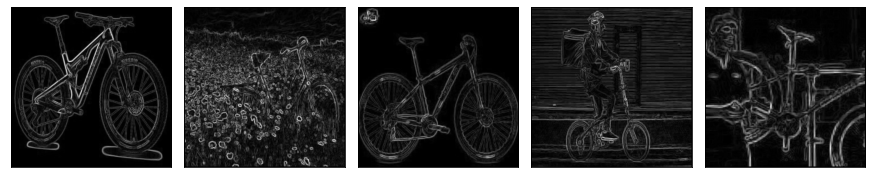

In [39]:
# Revision de algunas imagenes con Sobel
fig, ax = plt.subplots(nrows=1,ncols=5, figsize= (12,12), constrained_layout=True)

for i, row in enumerate(ax):
    row.imshow(images[i], cmap='gray')
    row.axes.get_xaxis().set_visible(False)
    row.axes.get_yaxis().set_visible(False)    

# fig.suptitle('Review Images with Sobel Filter')
plt.show();          

## Data Augmentation

### ImageDataGenerator for Train

In [40]:
# ImageDataGenerator for train data
train_generator = ImageDataGenerator(rescale = 1./255,
                                     rotation_range=40,
                                     width_shift_range=0.2,
                                     height_shift_range=0.2,
                                     shear_range=0.2,
                                     zoom_range=0.2,
                                     horizontal_flip=True,
                                     fill_mode='nearest').flow_from_directory(train_dir,
                                                                              target_size = (final_size, final_size),
                                                                              batch_size = 16,
                                                                              shuffle=True,
                                                                              color_mode="grayscale",
                                                                              class_mode = 'categorical',
                                                                              seed = 16626)

X_train, y_train = next(train_generator)

Found 5759 images belonging to 2 classes.


##### Previus Image Review

Some Images:



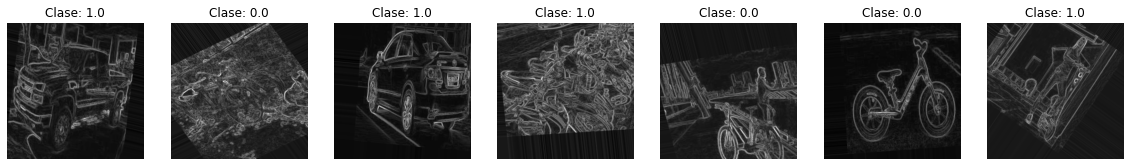

In [41]:
plot_7_images(X_train,y_train)

### ImageDataGenerator for Validation

In [42]:
# ImageDataGenerator for validation data
val_generator = ImageDataGenerator(rescale = 1./255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest').flow_from_directory(validation_dir,
                                                                            target_size = (final_size, final_size),
                                                                            batch_size = 16,
                                                                            shuffle=True,
                                                                            color_mode="grayscale",
                                                                            class_mode = 'categorical',
                                                                            seed = 16626)

X_val, y_val = next(val_generator)                                  

print('-- Image Dimensions --', X_val[0].shape)                                                                        

Found 1428 images belonging to 2 classes.
-- Image Dimensions -- (290, 290, 1)


##### Previus Image Review

Some Images:



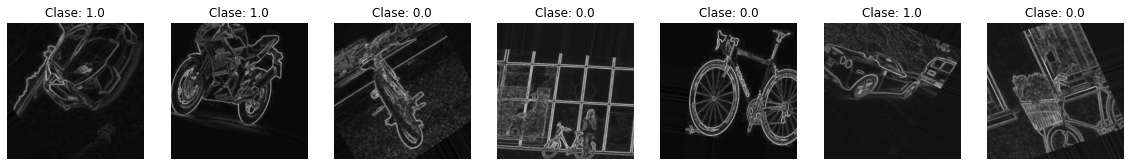

In [43]:
plot_7_images(X_val,y_val)

### ImageDataGenerator for Test

In [44]:
# ImageDataGenerator for test data
test_generator = ImageDataGenerator(rescale = 1./255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest').flow_from_directory(test_dir,
                                                                            target_size = (final_size, final_size),
                                                                            batch_size = 1000,
                                                                            shuffle=True,
                                                                            color_mode="grayscale",
                                                                            class_mode = 'categorical',
                                                                            seed = 16626)  
                                                                          
X_test, y_test = next(test_generator)

Found 894 images belonging to 2 classes.


##### Previus Image Review

Some Images:



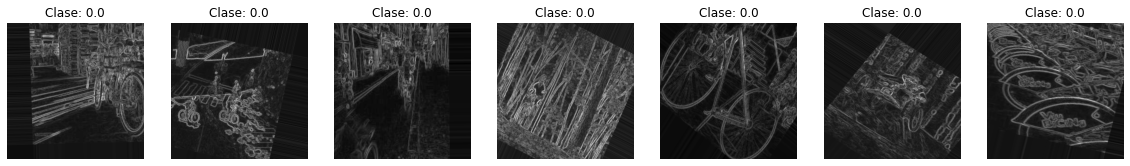

In [45]:
plot_7_images(X_test, y_test)

## Modelling ConvNet

### Model Architecture

```python
# Build the model using the functional API
i = Input(shape=X_train[0].shape)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(i)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
#x = MaxPooling2D((2, 2))(x)
x = GlobalMaxPooling2D()(x)
x = Flatten()(x)
#x = Dropout(0.5)(x)
x = Dense(2048, activation='relu')(x)
x = Dropout(0.5)(x)
#x = Dense(4096, activation='relu')(x)
x = Dense(2, activation='softmax')(x)

model = Model(i, x)
```

### Callback defined

```python
# Class for callback
class myCallback(tf.keras.callbacks.Callback):
    
	def on_epoch_end(self, epoch, logs={}):
		if(logs.get('acc') > accuracy_threshold):
			print("\nReached %2.2f%% accuracy, so stopping training!!" %(accuracy_threshold*100))
			self.model.stop_training = True
```

```python
# Defining steps_per_epoch for train and validation generators
step_size_train = train_generator.n//train_generator.batch_size
step_size_valid = val_generator.n//val_generator.batch_size

# Threshold for early stopping
accuracy_threshold = 0.98

# Instantiate a callback object
callbacks = myCallback()
```

### Compile and Fit Model

```python
# Compile
# Note: make sure you are using the GPU for this!
model.compile(optimizer = Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['acc', 
                       tf.keras.metrics.Precision(),
                       tf.keras.metrics.Recall()])
```

```python
# Fit
r = model.fit(train_generator, 
              validation_data = val_generator, 
              steps_per_epoch=step_size_train, 
              validation_steps=step_size_valid,
              callbacks=[callbacks],
              epochs=300, 
              verbose=2)
```

### Save the best model

```python
model.save('bike_class_v5.h5')
```

### Load final model

In [46]:
shutil.copyfile("/drive/MyDrive/Proyectos/Reconocimiento_Bicicleta/bike_class_v5.h5", "/tmp/bike_class_v5.h5")

'/tmp/bike_class_v5.h5'

In [47]:
model = tf.keras.models.load_model('/tmp/bike_class_v5.h5')

### Summary of the Model

In [48]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 290, 290, 1)]     0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 290, 290, 32)      320       
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 290, 290, 32)      9248      
_________________________________________________________________
batch_normalization_5 (Batch (None, 290, 290, 32)      128       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 145, 145, 32)      0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 145, 145, 32)      9248      
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 145, 145, 32)      9248

### Model evaluation

##### Performance Training

In [49]:
train_generator.batch_size = 6000
images_train, images_class = next(train_generator)

Some Images:



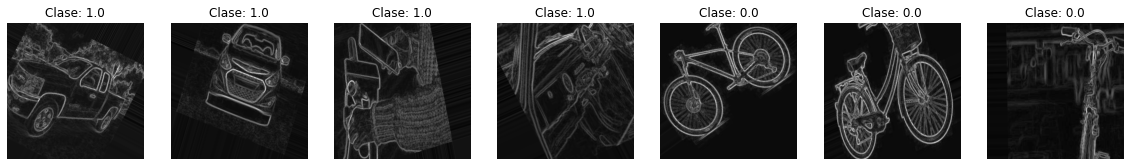

In [50]:
plot_7_images(images_train, images_class)

Confusion matrix, without normalization
[[2610   98]
 [  43 2767]]


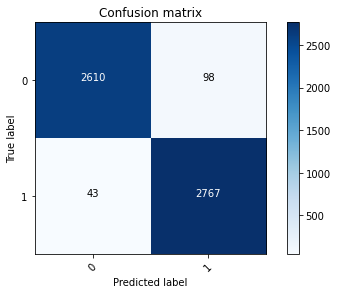

In [51]:
predict_classes = model.predict(images_train).argmax(axis=1)
original_classes = images_class.argmax(axis=1)
cm = confusion_matrix(original_classes, predict_classes)
plot_confusion_matrix(cm, list(range(2)))

In [52]:
print(classification_report(original_classes, predict_classes))

              precision    recall  f1-score   support

           0       0.98      0.96      0.97      2708
           1       0.97      0.98      0.98      2810

    accuracy                           0.97      5518
   macro avg       0.97      0.97      0.97      5518
weighted avg       0.97      0.97      0.97      5518



#### Plot loss per iteration training

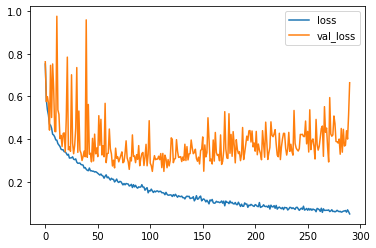

In [ ]:
# Plot loss per iteration
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend();

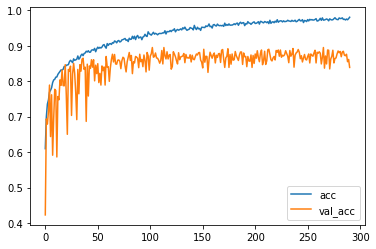

In [ ]:
# Plot accuracy per iteration
plt.plot(r.history['acc'], label='acc')
plt.plot(r.history['val_acc'], label='val_acc')
plt.legend();

#### Performance en validacion

In [53]:
val_generator.batch_size = 6000
images_train, images_class = next(val_generator)

Some Images:



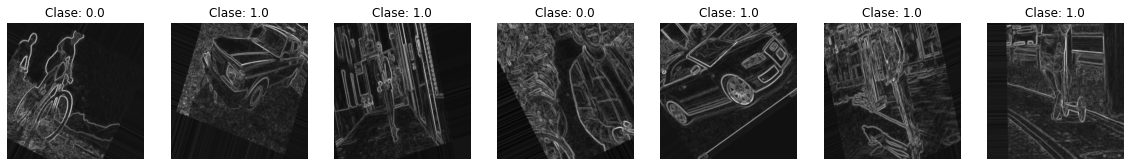

In [54]:
plot_7_images(images_train, images_class)

Confusion matrix, without normalization
[[334 155]
 [ 26 625]]


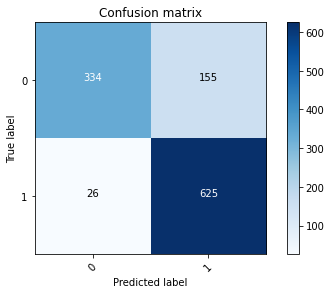

In [55]:
predict_classes = model.predict(images_train).argmax(axis=1)
original_classes = images_class.argmax(axis=1)
cm = confusion_matrix(original_classes, predict_classes)
plot_confusion_matrix(cm, list(range(2)))

In [56]:
print(classification_report(original_classes, predict_classes))

              precision    recall  f1-score   support

           0       0.93      0.68      0.79       489
           1       0.80      0.96      0.87       651

    accuracy                           0.84      1140
   macro avg       0.86      0.82      0.83      1140
weighted avg       0.86      0.84      0.84      1140



#### Performance en testing

Some Images:



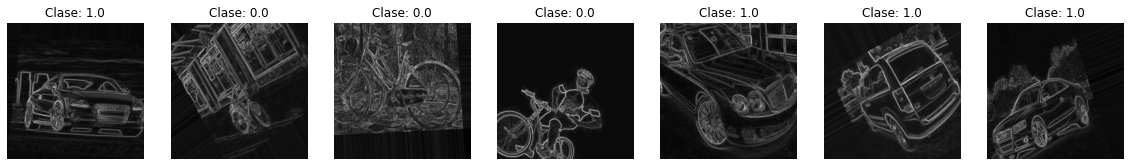

In [57]:
images_train, images_class = next(test_generator)
plot_7_images(images_train, images_class)

Confusion matrix, without normalization
[[349 121]
 [  6 418]]


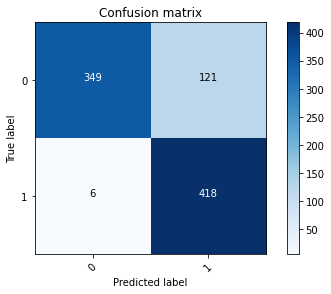

In [58]:
predict_classes = model.predict(images_train).argmax(axis=1)
original_classes = images_class.argmax(axis=1)
cm = confusion_matrix(original_classes, predict_classes)
plot_confusion_matrix(cm, list(range(2)))

In [59]:
print(classification_report(original_classes, predict_classes))

              precision    recall  f1-score   support

           0       0.98      0.74      0.85       470
           1       0.78      0.99      0.87       424

    accuracy                           0.86       894
   macro avg       0.88      0.86      0.86       894
weighted avg       0.88      0.86      0.86       894



## Conclusiones

### Show some misclassified examples

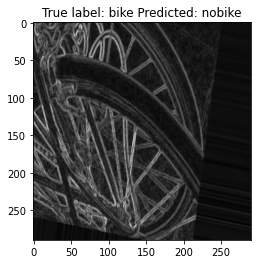

In [60]:
# label mapping
labels = '''bike
nobike'''.split()

# Show some misclassified examples
misclassified_idx = np.where(predict_classes != original_classes)[0]
i = np.random.choice(misclassified_idx).astype(int)

if images_train[i].shape[2] == 1:
    image1 = images_train[i][:, :, 0]
plt.imshow(image1, cmap='gray')
plt.title("True label: %s Predicted: %s" % (labels[original_classes[i]], labels[predict_classes[i]]));

### Testing with new images upload

In [ ]:
# Upload image
try:
  os.mkdir('/content/image/')
except:
  pass
uploaded = files.upload()

Saving 01622.jpg to 01622.jpg
Saving 01623.jpg to 01623.jpg
Saving 01624.jpg to 01624.jpg
Saving 01625.jpg to 01625.jpg
Saving 01626.jpg to 01626.jpg
Saving 5113823-1-11-f164ae9f40e8ac687015877172783544-640-0.jpg to 5113823-1-11-f164ae9f40e8ac687015877172783544-640-0 (1).jpg
Saving 828841001_1.jpg to 828841001_1.jpg
Saving bici 2.png to bici 2.png
Saving Bici.png to Bici (1).png
Saving bicicleta (1445).jpg to bicicleta (1445).jpg
Saving bicicleta (1468).jpg to bicicleta (1468).jpg
Saving bicicleta (1658).jpg to bicicleta (1658) (1).jpg
Saving bicicleta (1660).jpg to bicicleta (1660).jpg
Saving bicicleta (1662).jpg to bicicleta (1662) (1).jpg
Saving bicicleta (1664).jpg to bicicleta (1664) (2).jpg
Saving bike-at-sunrise-picture-id451266079.jpg to bike-at-sunrise-picture-id451266079 (1).jpg
Saving competitive-mood-picture-id186667614.jpg to competitive-mood-picture-id186667614 (1).jpg
Saving MicrosoftTeams-image (4).png to MicrosoftTeams-image (4) (3).png
Saving MicrosoftTeams-image.png 

Nombre de la foto: 01622.jpg
(290, 290, 1)
0.1849121


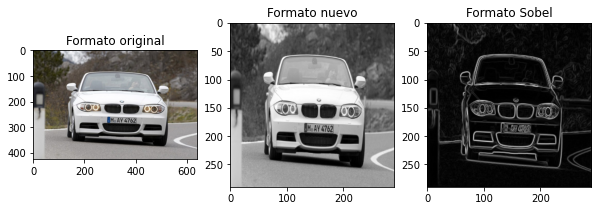

Prediction:  1
Probabilty:  1.4148395e-21
01622.jpg isn't a bike
.............................................

Nombre de la foto: 01623.jpg
(290, 290, 1)
0.18283488


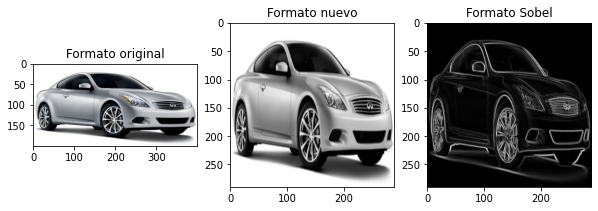

Prediction:  1
Probabilty:  2.991947e-30
01623.jpg isn't a bike
.............................................

Nombre de la foto: 01624.jpg
(290, 290, 1)
0.17213762


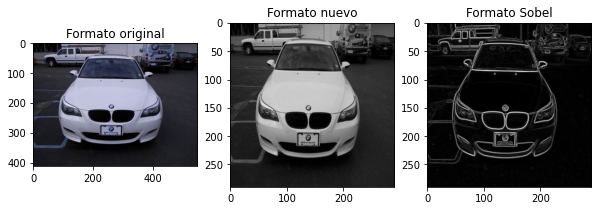

Prediction:  1
Probabilty:  1.7515737e-07
01624.jpg isn't a bike
.............................................

Nombre de la foto: 01625.jpg
(290, 290, 1)
0.18755648


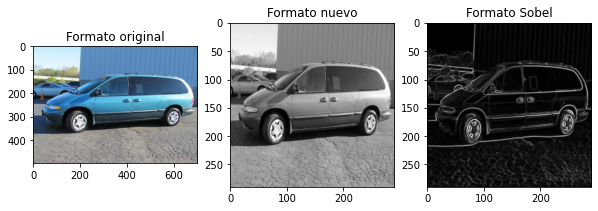

Prediction:  1
Probabilty:  9.787001e-38
01625.jpg isn't a bike
.............................................

Nombre de la foto: 01626.jpg
(290, 290, 1)
0.17469946


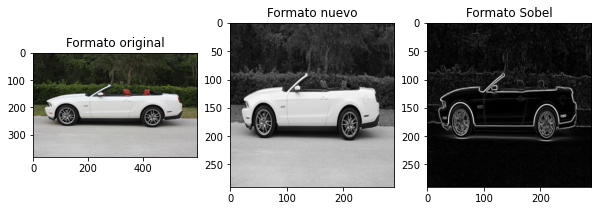

Prediction:  1
Probabilty:  2.08434e-28
01626.jpg isn't a bike
.............................................

Nombre de la foto: 5113823-1-11-f164ae9f40e8ac687015877172783544-640-0.jpg
(290, 290, 1)
0.15261286


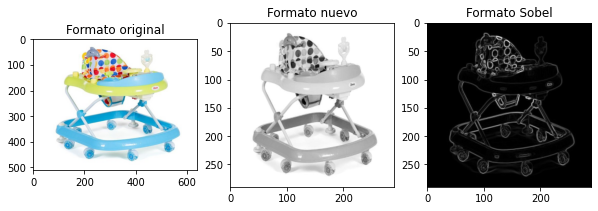

Prediction:  1
Probabilty:  2.729563e-10
5113823-1-11-f164ae9f40e8ac687015877172783544-640-0.jpg isn't a bike
.............................................

Nombre de la foto: 828841001_1.jpg
(290, 290, 1)
0.1435735


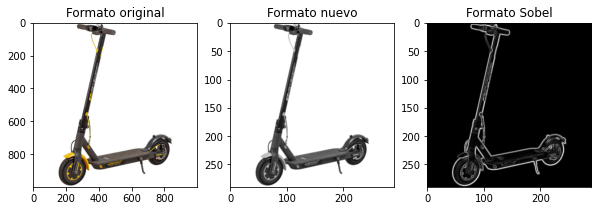

Prediction:  1
Probabilty:  9.12951e-18
828841001_1.jpg isn't a bike
.............................................

Nombre de la foto: bici 2.png
(290, 290, 1)
0.1936022


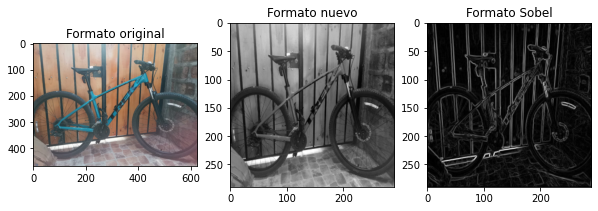

Prediction:  0
Probabilty:  1.0
bici 2.png is a bike
.............................................

Nombre de la foto: Bici.png
(290, 290, 1)
0.18890814


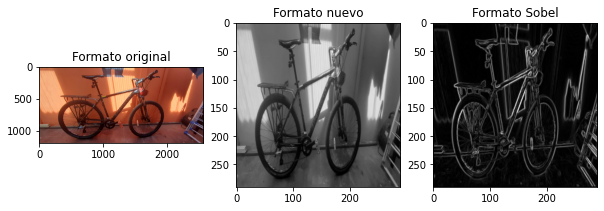

Prediction:  0
Probabilty:  1.0
Bici.png is a bike
.............................................

Nombre de la foto: bicicleta (1445).jpg
(290, 290, 1)
0.20211351


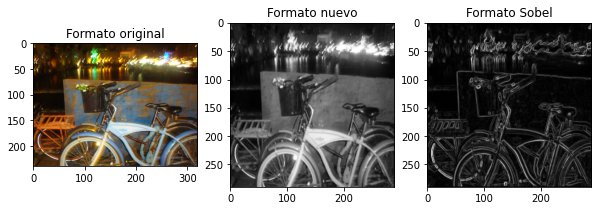

Prediction:  0
Probabilty:  0.9986072
bicicleta (1445).jpg is a bike
.............................................

Nombre de la foto: bicicleta (1468).jpg
(290, 290, 1)
0.25938335


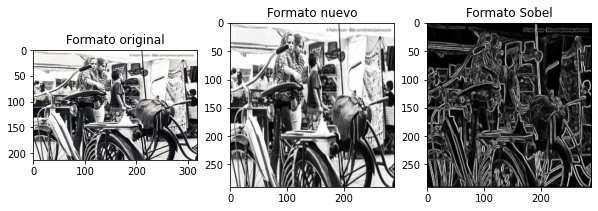

Prediction:  1
Probabilty:  0.1608455
bicicleta (1468).jpg isn't a bike
.............................................

Nombre de la foto: bicicleta (1658).jpg
(290, 290, 1)
0.24355316


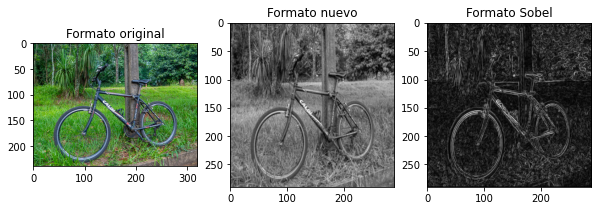

Prediction:  0
Probabilty:  1.0
bicicleta (1658).jpg is a bike
.............................................

Nombre de la foto: bicicleta (1660).jpg
(290, 290, 1)
0.2134772


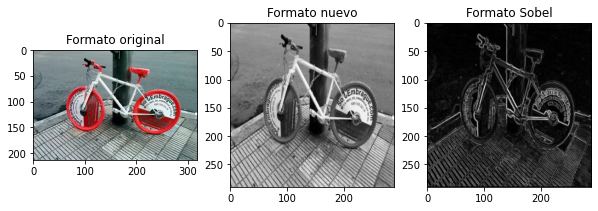

Prediction:  1
Probabilty:  0.05626133
bicicleta (1660).jpg isn't a bike
.............................................

Nombre de la foto: bicicleta (1662).jpg
(290, 290, 1)
0.21080095


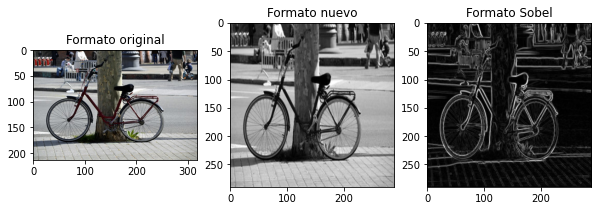

Prediction:  0
Probabilty:  1.0
bicicleta (1662).jpg is a bike
.............................................

Nombre de la foto: bicicleta (1664).jpg
(290, 290, 1)
0.20755534


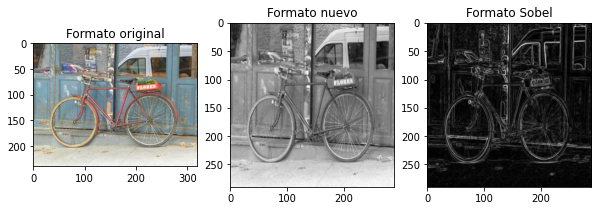

Prediction:  0
Probabilty:  1.0
bicicleta (1664).jpg is a bike
.............................................

Nombre de la foto: bike-at-sunrise-picture-id451266079.jpg
(290, 290, 1)
0.1471555


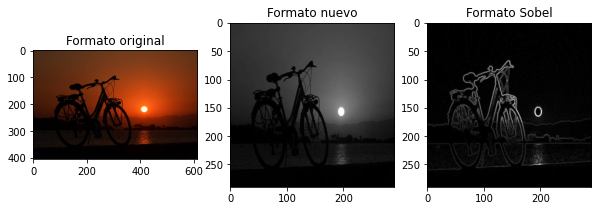

Prediction:  0
Probabilty:  0.9999964
bike-at-sunrise-picture-id451266079.jpg is a bike
.............................................

Nombre de la foto: competitive-mood-picture-id186667614.jpg
(290, 290, 1)
0.1763088


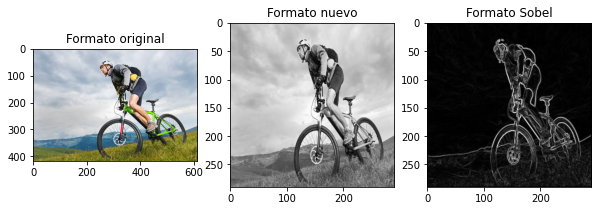

Prediction:  0
Probabilty:  1.0
competitive-mood-picture-id186667614.jpg is a bike
.............................................

Nombre de la foto: MicrosoftTeams-image (4).png
(290, 290, 1)
0.18261531


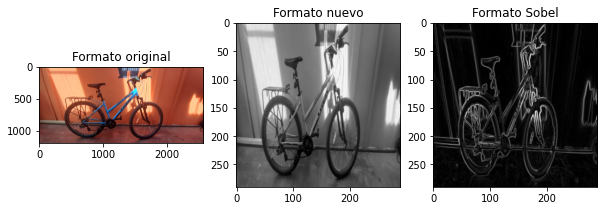

Prediction:  0
Probabilty:  0.999967
MicrosoftTeams-image (4).png is a bike
.............................................

Nombre de la foto: MicrosoftTeams-image.png
(290, 290, 1)
0.17185155


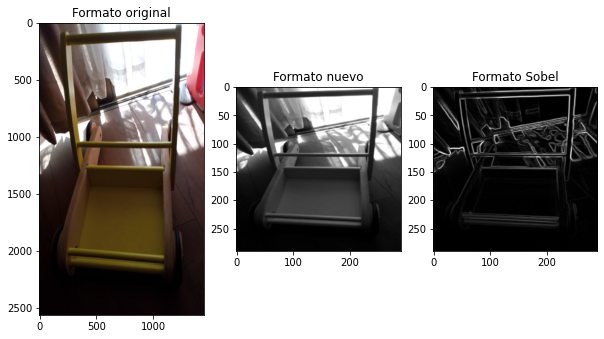

Prediction:  1
Probabilty:  1.7359398e-06
MicrosoftTeams-image.png isn't a bike
.............................................

Nombre de la foto: Moto_Juancho (2).png
(290, 290, 1)
0.20438586


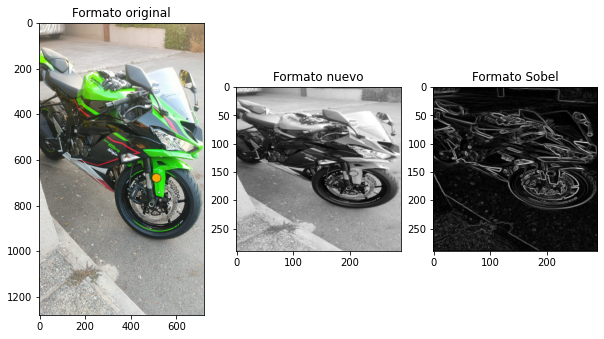

Prediction:  1
Probabilty:  1.583148e-08
Moto_Juancho (2).png isn't a bike
.............................................

Nombre de la foto: Moto_Juancho 3.png
(290, 290, 1)
0.19165553


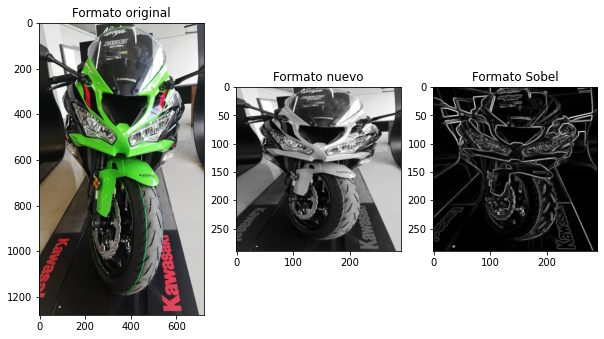

Prediction:  1
Probabilty:  0.00037665706
Moto_Juancho 3.png isn't a bike
.............................................

Nombre de la foto: Moto_juancho 4.png
(290, 290, 1)
0.19226515


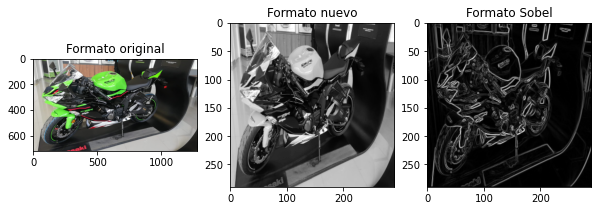

Prediction:  1
Probabilty:  2.1897949e-11
Moto_juancho 4.png isn't a bike
.............................................

Nombre de la foto: Moto_Juancho.png
(290, 290, 1)
0.21223935


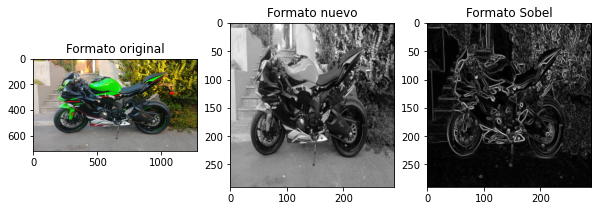

Prediction:  1
Probabilty:  8.620477e-15
Moto_Juancho.png isn't a bike
.............................................

Nombre de la foto: row-of-ride-sharing-electric-scooters-parked-on-street-in-gaslamp-picture-id1263556504.jpg
(290, 290, 1)
0.20459321


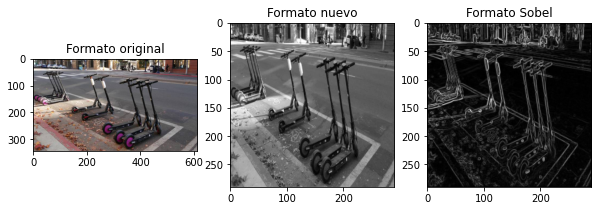

Prediction:  1
Probabilty:  1.5262219e-13
row-of-ride-sharing-electric-scooters-parked-on-street-in-gaslamp-picture-id1263556504.jpg isn't a bike
.............................................

Nombre de la foto: sister-with-brother-riding-scooter-and-bike-on-driveway-at-home-picture-id904506354.jpg
(290, 290, 1)
0.21292934


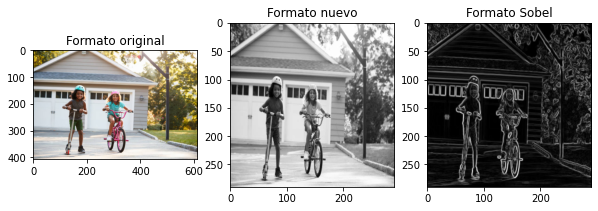

Prediction:  1
Probabilty:  2.0642844e-06
sister-with-brother-riding-scooter-and-bike-on-driveway-at-home-picture-id904506354.jpg isn't a bike
.............................................

Nombre de la foto: WhatsApp Image 2021-03-26 at 13.04.49.jpeg
(290, 290, 1)
0.23953933


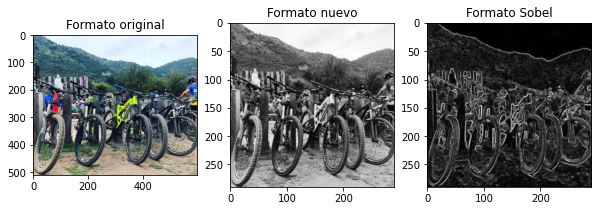

Prediction:  0
Probabilty:  0.9997954
WhatsApp Image 2021-03-26 at 13.04.49.jpeg is a bike
.............................................

Nombre de la foto: WhatsApp Image 2021-03-26 at 13.05.02.jpeg
(290, 290, 1)
0.20784639


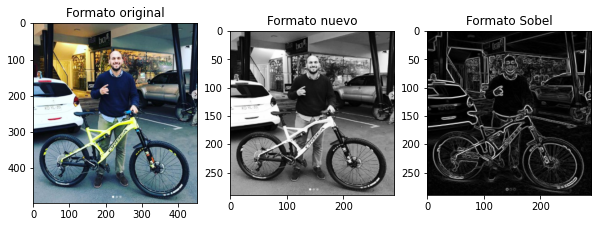

Prediction:  0
Probabilty:  1.0
WhatsApp Image 2021-03-26 at 13.05.02.jpeg is a bike
.............................................

Nombre de la foto: WhatsApp Image 2021-03-26 at 13.05.15.jpeg
(290, 290, 1)
0.16290307


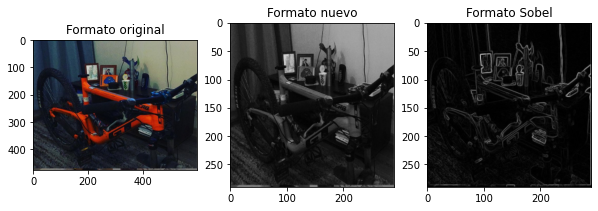

Prediction:  1
Probabilty:  3.192154e-05
WhatsApp Image 2021-03-26 at 13.05.15.jpeg isn't a bike
.............................................

Nombre de la foto: woman-on-scooter-on-parisian-street-picture-id1128757501.jpg
(290, 290, 1)
0.22714071


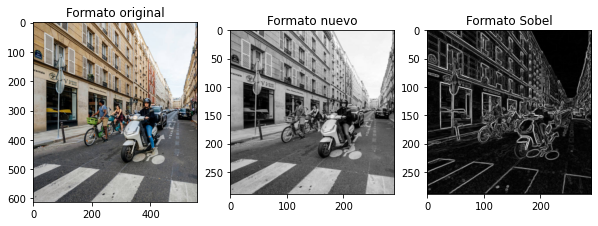

Prediction:  1
Probabilty:  1.9488583e-08
woman-on-scooter-on-parisian-street-picture-id1128757501.jpg isn't a bike
.............................................



In [ ]:
# Clasiffier Image
for fn in uploaded.keys():
  print('Nombre de la foto: {}'.format(fn))
  
  path = '/content/' + fn

  new_path = '/content/image/' + fn

  orig_print = io.imread(path)
  original = io.imread(path, as_gray=True).astype(np.float32)
  img_resize = resize(original, (final_size, final_size), anti_aliasing=True)
  sobel_img = sobel(img_resize)
  
  plt.imsave(new_path, sobel_img)

  final_img = tf.keras.preprocessing.image.load_img(new_path, color_mode='grayscale', target_size=(final_size, final_size))
  final_img = keras.preprocessing.image.img_to_array(final_img)
  final_img = final_img / 255.
  print(final_img.shape)
  x = np.expand_dims(final_img, axis=0)
  print(x.mean())

  #print('Formato original: {}, Tipo: {}'.format(original.shape, original.dtype))
  #print('Formato nuevo: {}, Tipo: {}'.format(img_resize.shape, img_resize.dtype))
  #print('Formato Sobel: {}, Tipo: {}'.format(sobel_img.shape, sobel_img.dtype))

  f, axarr = plt.subplots(nrows=1,ncols=3, figsize= (10,10))
  plt.sca(axarr[0]); 
  plt.imshow(orig_print, cmap='gray'); plt.title('Formato original')
  plt.sca(axarr[1]); 
  plt.imshow(img_resize, cmap='gray'); plt.title('Formato nuevo')
  plt.sca(axarr[2]); 
  plt.imshow(sobel_img, cmap='gray'); plt.title('Formato Sobel')
  plt.show()

  pred = model.predict(x)
  
  classes = model.predict(x).argmax(axis=1)
  prob = model.predict(x)[0][0]
 
  print('Prediction: ', classes[0])
  print('Probabilty: ', prob)
    
  if classes[0] == 0:
    print(fn + " is a bike")
  else:
    print(fn + " isn't a bike")

  print('.............................................\n')